# [ASSIGNMENT-3] Klasifikasi cats vs dogs menggunakan supervised learning
Nama : Ichwan Rizky Wahyudin\
NIM : 1301213434\
Kelas : IF-45-09\
Metode : Support Vector Machine(SVM)
Link Source Code : https://github.com/irizkyw/ComputerVision/W5_Assignment3

In [87]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


### Image Augmentation
Penambahan noise pada data training agar tidak terjadinya overfitting

In [88]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [89]:
def add_noise(image, mean=0, var=0.1):
    """
    Adds Gaussian noise to an image.

    Args:
        image (numpy.ndarray): Input image.
        mean (float, optional): Mean of the Gaussian distribution (default is 0).
        var (float, optional): Variance of the Gaussian distribution (default is 0.1).

    Returns:
        numpy.ndarray: Noisy image.
    """
    row, col, ch = image.shape
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy_image = image + gauss
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image.astype(np.float32)



In [135]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=add_noise
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [136]:
image_size = (135, 135)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(image_size[0], image_size[1]),
    batch_size=32,
    class_mode='binary'
)

valid_generator = validation_datagen.flow_from_directory(
    'data/validation',
    target_size=(image_size[0], image_size[1]),
    batch_size=32,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


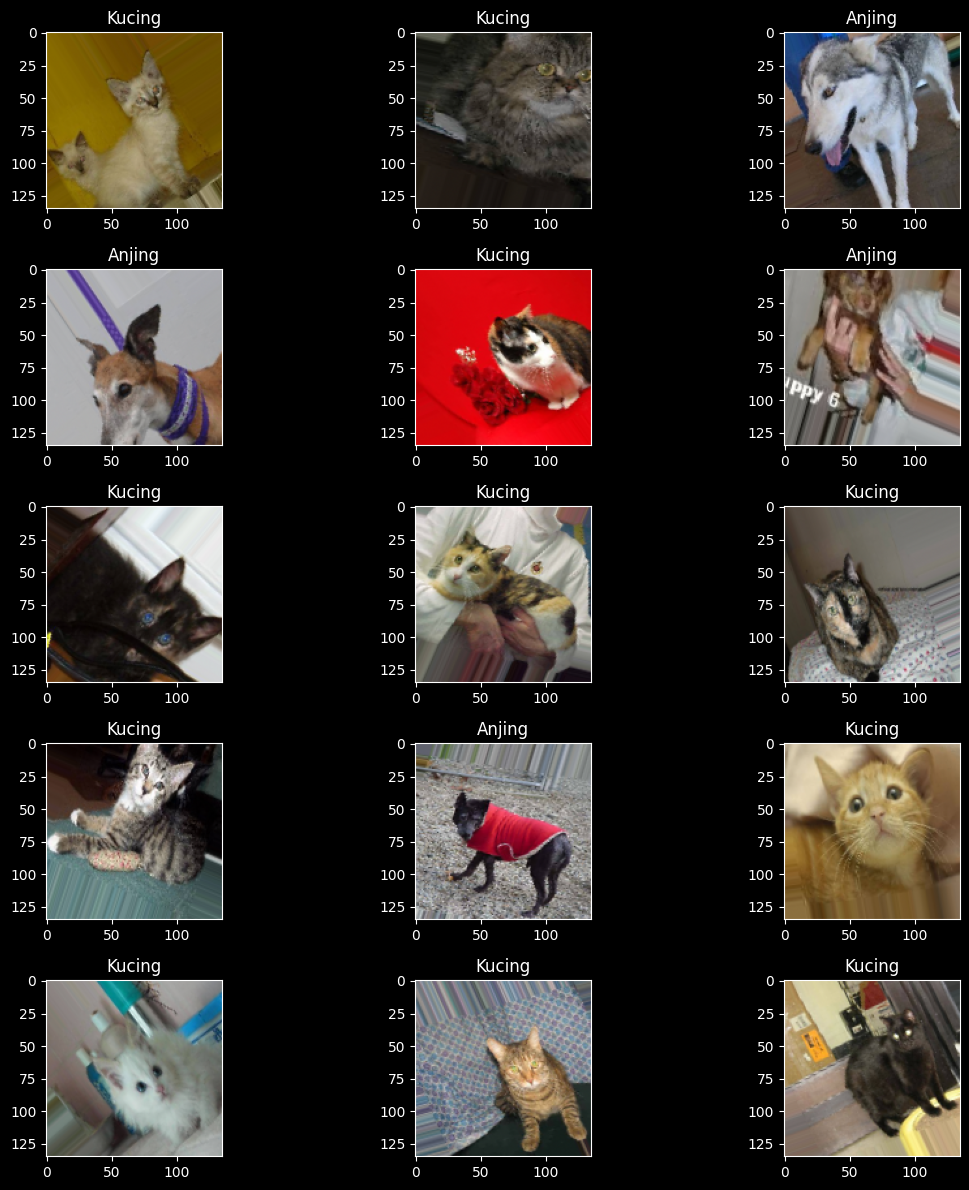

In [162]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        if Y_batch[0] == 0:
            plt.title('Kucing')
        else:
            plt.title('Anjing')
        break
plt.tight_layout()
plt.show()



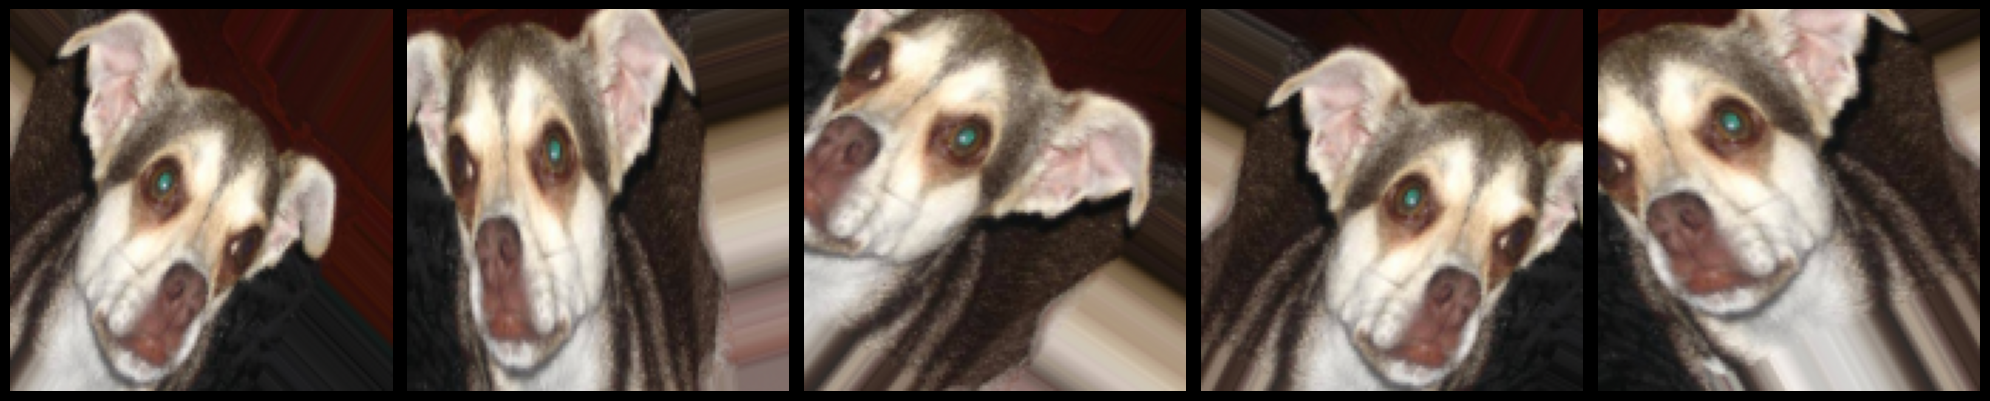

In [137]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)


### Model SVM

In [138]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

In [139]:
model_cnn = Sequential([
    tf.keras.layers.Conv2D(32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[image_size[0], image_size[1], 3]),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Conv2D(64,padding="same",kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Conv2D(128,padding="same",kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, kernel_regularizer=l2(0.01), activation='linear')
])

model_cnn.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 68, 68, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 34, 34, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,081 (4.36 MB)

 Trainable params: 1,142,081 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [140]:
model_cnn.compile(optimizer='adam', loss='hinge', metrics=['accuracy'])

In [141]:
history = model_cnn.fit(train_generator, validation_data=valid_generator, epochs=100)

Epoch 1/100


d:\anaconda3\envs\yolov8\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 310ms/step - accuracy: 0.5215 - loss: 1.0225 - val_accuracy: 0.5920 - val_loss: 0.9719
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 313ms/step - accuracy: 0.5382 - loss: 0.9806 - val_accuracy: 0.6450 - val_loss: 0.8624
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 323ms/step - accuracy: 0.5555 - loss: 0.9194 - val_accuracy: 0.5060 - val_loss: 0.9079
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 304ms/step - accuracy: 0.5447 - loss: 0.8996 - val_accuracy: 0.5560 - val_loss: 0.9444
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 306ms/step - accuracy: 0.6121 - loss: 0.8498 - val_accuracy: 0.6120 - val_loss: 0.7381
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 307ms/step - accuracy: 0.6301 - loss: 0.8006 - val_accuracy: 0.6390 - val_loss: 0.7689
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 330ms/step - accuracy: 0.6019 - loss: 0.8017 - val_accuracy: 0.6830 - val_loss: 0.7374
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 371ms/step - accuracy: 0.6484 - loss: 0.7569 - val_accuracy

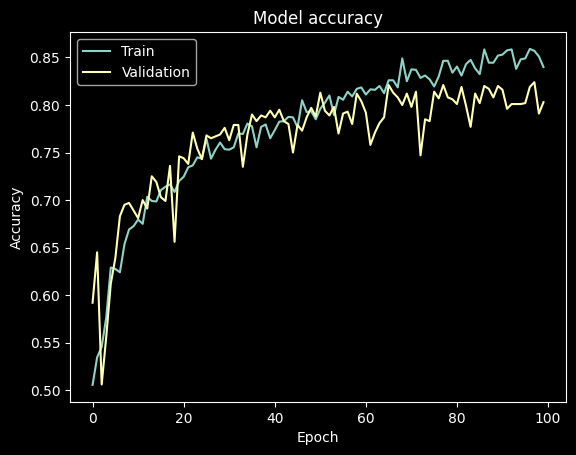

In [142]:
# Plot Accruacy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


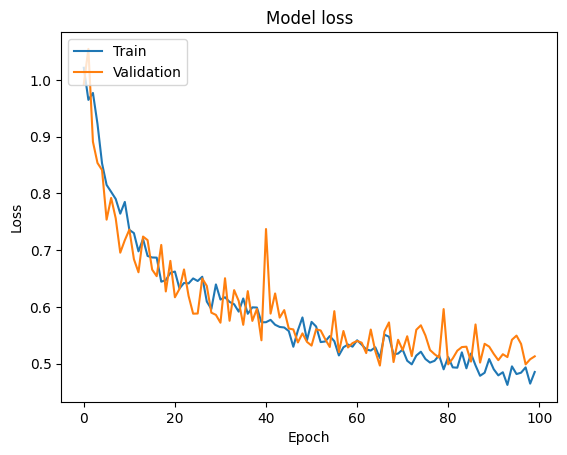

In [ ]:
# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [155]:
model_cnn.save('model_cnn_best.h5')

# Prediksi citra dengan load model yang telah di export/di simpan

In [158]:
from tensorflow.keras.models import load_model

loaded_model = load_model('model_cnn_best.h5')

data_image = './testing_data/9_anjing.webp'

image_predict =  tf.keras.preprocessing.image.load_img(data_image, target_size=(image_size[0], image_size[1]))
image_predict =  tf.keras.preprocessing.image.img_to_array(image_predict)
image_predict =  np.expand_dims(image_predict, axis=0)
result = loaded_model.predict(image_predict)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
[[591.368]]


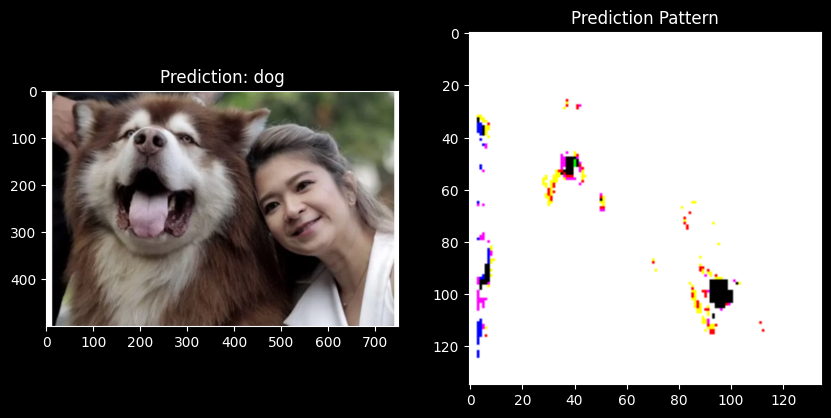

dog


In [159]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig = plt.style.use('dark_background')

# Plot original image
axs[0].imshow(tf.keras.preprocessing.image.load_img(data_image))
axs[0].set_title('Prediction: ' + ('cat' if result[0] < 0 else 'dog'))

# Plot prediction pattern
axs[1].imshow(image_predict[0])
axs[1].set_title('Prediction Pattern')

plt.show()

if result[0] < 0:
    prediction = 'cat'
else:
    prediction = 'dog'

print(prediction)